# Qwen2.5-VL お試し推論デモ

このnotebookでは、Qwen2.5-VLモデルを使用した画像理解や推論のデモを実行できます。

## 必要なライブラリのインストール

まずは必要なライブラリをインストールします：

```bash
pip install transformers==4.51.3 accelerate
pip install qwen-vl-utils[decord]
pip install torch torchvision
pip install pillow requests
```

## モデルについて

Qwen2.5-VLは、Alibaba Cloud開発の最新のビジョン言語モデルです。以下の特徴があります：

- **マルチモーダル理解**: 画像、動画、テキストを統合的に理解
- **動的解像度**: 様々な解像度の画像に対応
- **Flash Attention**: 高効率な推論をサポート
- **複数サイズ**: 3B、7B、32B、72Bパラメータのモデルが利用可能

In [1]:
# モデルの初期化とセットアップ
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# GPUの利用可能性を確認
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用デバイス: {device}")

# モデル名を設定（GPU メモリに応じて変更可能）
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"  # 軽量版
# model_name = "Qwen/Qwen2.5-VL-7B-Instruct"  # 標準版（より高精度）

print(f"モデル {model_name} を読み込み中...")

# モデルとプロセッサーを初期化
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name, 
    torch_dtype="auto", 
    device_map="auto"
)

# プロセッサーの初期化（画像解像度の設定）
min_pixels = 256 * 28 * 28
max_pixels = 1280 * 28 * 28
processor = AutoProcessor.from_pretrained(
    model_name, 
    min_pixels=min_pixels, 
    max_pixels=max_pixels
)

print("モデルの初期化完了！")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用デバイス: cuda
モデル Qwen/Qwen2.5-VL-3B-Instruct を読み込み中...


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.63s/it]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


モデルの初期化完了！


In [2]:
# 画像推論のヘルパー関数
def run_image_inference(image_url, text_prompt):
    """
    画像URLまたはローカルパスと質問テキストを使って推論を実行
    """
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_url},
                {"type": "text", "text": text_prompt},
            ],
        }
    ]
    
    # チャットテンプレートを適用
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    
    # 画像と動画の情報を処理
    image_inputs, video_inputs = process_vision_info(messages)
    
    # プロセッサーでテキストと画像を処理
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    
    # 推論実行
    generated_ids = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0]

print("画像推論関数の準備完了！")

画像推論関数の準備完了！


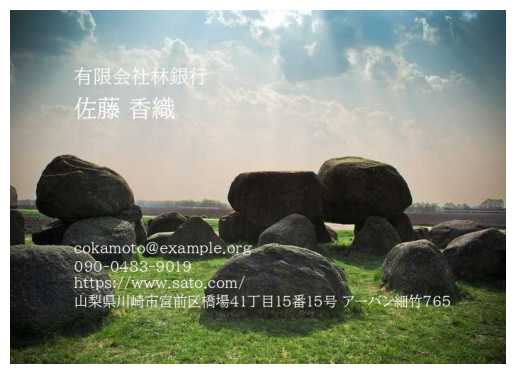

📸 画像解析デモ1: 画像の詳細説明


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


質問: この画像を詳しく説明してください。
回答: この画像は、広大な草原に巨大な石の列が並んでいる風景写真です。背景には晴れた空と雲があり、太陽光が地面に当たっている様子が見受けられます。石は大きな円形で、その上部には小さな石が積み重ねられています。

画像の下部には、日本語で「有限会社林銀行 佐藤 香織」という名前が記載されており、これはおそらく人物の名前や関連する組織の名前を示しています。また、メールアドレス「cokamoto@example.org」、電話番号「090-0483-9019」、ウェブサイト「https://www.sato.com/」が記載されており、これらは個人または組織の連絡先情報である可能性があります。

さらに、住所「山梨県川崎市宮前区橋場41丁目15番15号 アーバン細竹765」も記載されており、これは具体的な場所を示しているものと思われます。全体的に、この画像は広大な自然環境と人間の活動が

📸 画像解析デモ2: 特定要素についての質問
質問: この画像に写っている動物は何ですか？何をしていますか？
回答: この画像には動物は写っていません。画像の主な要素は、大きな石の群れと青い空です。

📸 画像解析デモ3: 色や雰囲気の分析
質問: この画像に写っている動物は何ですか？何をしていますか？
回答: この画像には動物は写っていません。画像の主な要素は、大きな石の群れと青い空です。

📸 画像解析デモ3: 色や雰囲気の分析
質問: この写真の色調や雰囲気について教えてください。
回答: この写真は、自然の美しさと静けさを表現しています。色調は全体的に落ち着いたトーンで、青い空と緑の草が主な色です。雲が浮かんでおり、太陽の光が差し込む様子が印象的です。全体的に平和で穏やかな雰囲気が漂っています。
CPU times: user 16 s, sys: 3.98 s, total: 20 s
Wall time: 20 s
質問: この写真の色調や雰囲気について教えてください。
回答: この写真は、自然の美しさと静けさを表現しています。色調は全体的に落ち着いたトーンで、青い空と緑の草が主な色です。雲が浮かんでおり、太陽の光が差し込む様子が印象的です。全体的に平和で穏やかな雰囲気が漂っています。
CPU times: user 16 s, s

In [3]:
%%time
# デモ1: インターネット画像の解析
# サンプル画像URL（Qwen公式のデモ画像）
sample_image_url = "/workspace/input/generate_image/test/image/2.png"

sample_img = Image.open(sample_image_url)
plt.imshow(sample_img)
plt.axis('off')  # 軸を非表示にする
plt.show()

# 画像の詳細説明を求める
print("📸 画像解析デモ1: 画像の詳細説明")
print("=" * 50)
prompt1 = "この画像を詳しく説明してください。"
result1 = run_image_inference(sample_image_url, prompt1)
print(f"質問: {prompt1}")
print(f"回答: {result1}")
print()

# 画像内の特定要素について質問
print("📸 画像解析デモ2: 特定要素についての質問")
print("=" * 50)
prompt2 = "この画像に写っている動物は何ですか？何をしていますか？"
result2 = run_image_inference(sample_image_url, prompt2)
print(f"質問: {prompt2}")
print(f"回答: {result2}")
print()

# 画像の色や雰囲気について
print("📸 画像解析デモ3: 色や雰囲気の分析")
print("=" * 50)
prompt3 = "この写真の色調や雰囲気について教えてください。"
result3 = run_image_inference(sample_image_url, prompt3)
print(f"質問: {prompt3}")
print(f"回答: {result3}")

In [4]:
sample_image_url = "/workspace/input/generate_image/test/image/2.png"
prompt1 = "please describe image.<image>"

"""
画像URLまたはローカルパスと質問テキストを使って推論を実行
"""
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": sample_image_url},
            {"type": "text", "text": prompt1},
        ],
    }
]

# チャットテンプレートを適用
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# 画像と動画の情報を処理
image_inputs, video_inputs = process_vision_info(messages)

# プロセッサーでテキストと画像を処理
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

inputs["input_ids"]

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151

In [5]:
# @title inference function
def inference(image_path1, image_path2, first_prompt, second_prompt, prompt, sys_prompt="You are a helpful assistant.", max_new_tokens=4096, return_input=False):
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)
    image_local_path1 = image_path1
    image_local_path2 = image_path2

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": first_prompt},
                {"image": image_local_path1},
                {"type": "text", "text": second_prompt},
                {"image": image_local_path2},
                {"type": "text", "text": prompt},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image1, image2], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

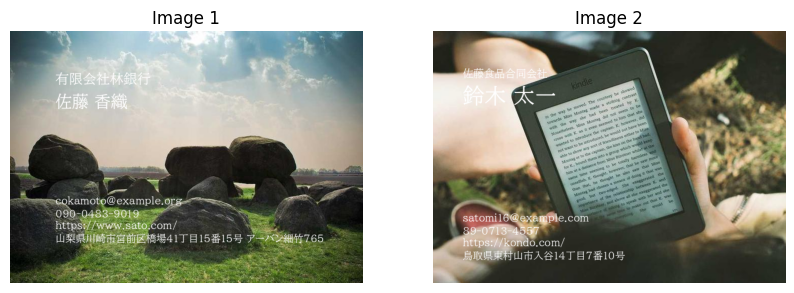

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Image 1: <|vision_start|><|image_pad|><|vision_end|>Image 2: <|vision_start|><|image_pad|><|vision_end|>Read all the text in the image.<|im_end|>
<|im_start|>assistant



In [6]:
image_path1 = "/workspace/input/generate_image/test/image/2.png"
image_path2 = "/workspace/input/generate_image/test/image/5.png"
first_prompt = "Image 1: "
second_prompt = "Image 2: "
prompt = "Read all the text in the image."

image1 = Image.open(image_path1)
image2 = Image.open(image_path2)

# image1, image2を表示
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Image 1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Image 2")
plt.axis('off')
plt.show()

## Use a local HuggingFace model to inference.
response = inference(image_path1, image_path2, first_prompt=first_prompt, second_prompt=second_prompt, prompt=prompt)

In [7]:
print(response)

有限会社林銀行
佐藤 香織
cokamoto@example.org
090-0483-9019
https://www.sato.com/
山梨県川崎市宮前区橋場41丁目15番15号 アーバン細竹765

佐藤食品合同会社
鈴木 太一
satomi16@example.com
89-0713-4557
https://kondo.com/
鳥取県東村山市入谷14丁目7番10号
